In [1]:
import matplotlib.pyplot as plt
import torch
import math

In [2]:
# 학습용 데이터
x = torch.linspace(-math.pi, math.pi, 1000)
# 정답
y = torch.sin(x)

In [3]:
# 3차 다항식
# f(x) = ax**3 + bx**2 + cx + d
# 초기화
a,b,c,d = torch.randn(()),torch.randn(()),torch.randn(()),torch.randn(())
y_random = a*x**3 + b*x**2 + c*x + d

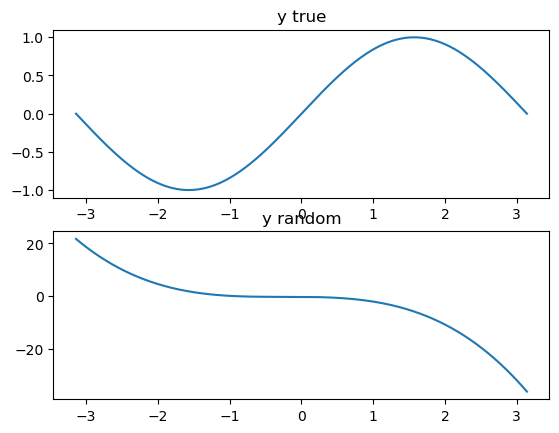

In [4]:
# 시각화
# 1. 실제값 시각화
plt.subplot(2,1,1)
plt.title('y true')
plt.plot(x,y)
# 2. 임의의 가중치로 만든 예측용 값으로 시각화
plt.subplot(2,1,2)
plt.title('y random')
plt.plot(x,y_random)

plt.show()

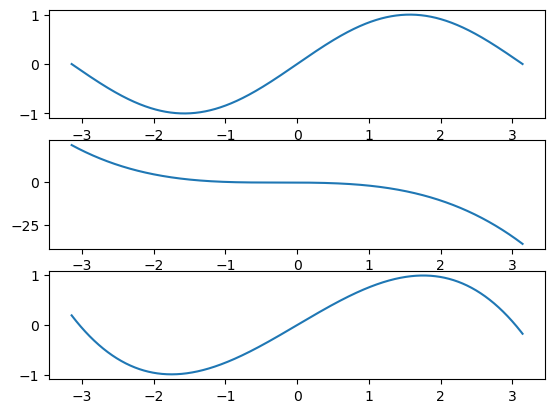

In [5]:
# 파라미터 정의
learning_rate= 1e-6
total_loss = []
for epoch in range(2000):
    # forward
    y_pred = a*x**3 + b*x**2 + c*x + d  
    # 손실 정의  MSE(평균제곱오차)  # 오차를 제곱하는 이유는 음수를 방지해서 크기만 보도록
    # 오차가 큰 값에 더 큰 패널티 부여
    loss = (y_pred - y).pow(2).mean().item() # 텐서에 저장된 숫자값만 추출 (그래프 추적을 피함)
    total_loss.append(loss)
    # 역전파 계산(Back Propagation) loss를 줄이기 위해서 a,b,c,d 어느 방향으로 움직여야할지 계산
    # 미분
    grad_y_pred = 2.0*(y_pred - y) # 기울기의 미분값
    grad_a = 2.0*(grad_y_pred*x**3).sum()
    grad_b = 2.0*(grad_y_pred*x**2).sum()
    grad_c = 2.0*(grad_y_pred*x).sum()
    grad_d = 2.0*(grad_y_pred).sum()
    # 가중치 업데이트
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

plt.subplot(3,1,1)
plt.plot(x,y)
plt.subplot(3,1,2)
plt.plot(x,y_random)
plt.subplot(3,1,3)
plt.plot(x, y_pred)

D-loss / D-a
D-loss / D-b
D-loss / D-c
D-loss / D-d

loss는 파라미터들과 직접 연관이 없음
다만 다음과 같은 연쇠구조를 가진다(chain)

a,b,c,d -> ypred -> loss
loss = (ypred - loss)

D-loss / D-a = D-ypred / D-a @ D-loss / D-ypred

- D-loss / D-ypred = 2x(ypred - y)

- D-ypred / D-a = x**3

In [6]:
# 보스턴 집값 예측
# dataset
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [7]:
data.shape

(506, 13)

In [8]:
# pytorch
# 미분을 자동으로 계산
# 계산된 미분을 optimizer를 통해 적용 : 최적화 알고리즘
import torch
from torch import nn
from torch.optim.adam import Adam
# 모델 정의
model = nn.Sequential(
    nn.Linear(data.shape[1], 100), # 13개의 데이터를 입력받아서 결과를 100개 즉 100개를 예측
    nn.ReLU(),
    nn.Linear(100, 1) # 100개의 예측결과를받아서 최종 1개를 예측
)

batch_size = 100
learning_rate = 1e-03  # 0.001

# 옵티마이저 정의
optim = Adam(model.parameters(), lr=learning_rate)
target = target.reshape(-1, 1)

# 학습루프
for epoch in range(200):
    for i in range(len(data) // batch_size):
        start = i * batch_size
        end = start + batch_size
        X = torch.FloatTensor(data[start:end])
        y = torch.FloatTensor(target[start:end])

        optim.zero_grad() # 학습이후 다음 학습에 이전 가중치가 계산되는것을 방지
        preds = model(X) # 순전파.. forward 
        loss = nn.MSELoss()(preds, y) # preds, 정답 shape 같아야함
        loss.backward() # 기울기 계산  각 파라미터의 그레이던트를 자동으로 계산  .grad 저장
        optim.step() # 옵티마이저가 .grad 정보를 사용해서 파라미터를 갱신
    if epoch % 20 == 0:
        print(f'epoch : {epoch + 1}, loss : {loss.item()}')

epoch : 1, loss : 243.47914123535156
epoch : 21, loss : 21.19918441772461
epoch : 41, loss : 18.604806900024414
epoch : 61, loss : 16.86762237548828
epoch : 81, loss : 15.682733535766602
epoch : 101, loss : 14.905374526977539
epoch : 121, loss : 14.292778015136719
epoch : 141, loss : 13.822168350219727
epoch : 161, loss : 13.527331352233887
epoch : 181, loss : 13.248514175415039


```
순전파 : X -> model -> preds -> loss 
역전파 : dloss/lpreds 계산해서 각 선형층의 파라미터(가중치,편향)로 전파
loss.backward() 호출되어서 pytorch autograd가 연쇄법칙(chain rule)을 이용해서 각 파라미터의 .grad를 채움
optim.step() : .grad를 읽어서 파라미터를 갱신

ReLU(활성화 함수) : max(0,z)
z가 음수이면 0, 양수면 그대로 전달
역전파
    - z > 0   dReLU/dz = 1
    - z <= 0  dReLU/dz = 0
    - 비선형을 제공해서 계산이 간단해진다
    - 기울기 소실이 sigmoid tanh 보다 유리
    - 음수이면 0이니깐.. 일부 뉴런이 비활성화되어 표현이 희소해진다 -> LeakyReLU 

Adam : 옵티마이저
    - 모멘텀과 스케일 조정 두가지 방법을 결합
    - 적응적 학습률 : 파라미터별로 학습률을 조정 -> 초기값 안정적
    - 빠른 수렴 : SGD 보다 빠름
    - 튜닝이 거의 필요없음, 기본 파라미터가 lr = 0.001 도 좋은 성능
    - 단점 : 과적합이 다른 최적화 모델에 비해 발생하기 쉬운 구조
```

```
옵티마이져 : 모델 파라미터를 손실이 줄어들게 갱신하는 역할
p_t : 현재 파라미터
n : 학습률
gt : 현재 그레디언트

p_t+1 = p_t - n*gt
단점:
    기울기가 들쑥날쑥(노이즈에 약함)
    모든 파라미터가 같은 학습률을 적용(비효율적)
    --> 모멘텀, 스케일 조정

모멘텀 Momentum
    이전 기울기의 방향을 "기억"해서 관성처럼 부드럽게 이동하는 기법
    vi : 누적된 속도 또는 1차 모멘텀
    gt : 현재 그레디언트 
    b1 : 모멘텀의 개수(보통 0.9)
    n  : 학습률
    vt : b1vt-1 + (1-b1)gt
        pt+1 = pt - n*vt
시점
    t : 1         단순히 g1을 따라감
    t : 2         이전 속도 v1의 일부를 남겨서 새로운 방향에 더해
    t -> infi     여러 스텝동안 방향이 일정하면 점점 가속되어 빠르게 수렴
기울기가 변해도 관성때문에 부드럽게 움직임

스케일 조정
    파라미터의 기울기의 크기를 고려해서 학습률을 자동으로 조정
    과거 파라미터의 크기를 추적해서 큰 변동이 있었던 파라미터는 작게, 작은 변동은 크게 이동

아담 : 모멘텀 + 스케일 조정  하이브리드 방식
    step 1 : 모멘텀
    step 2 : 스케일 조정
    step 3 : 바이서 보정  초기 스텝에서는 m,v = 0 보정
    step 4 : 모멘텀으로 얻은 방향 + 스케일 조정된 학습률 이동

SGD                     단순히 그레디언트                       진동 심함, 느림
Momentum                과거 방향의 관성 사용                   진동 완화, 빠른 수렴
RMSProp / AdaGrad       그레디언트 제곱의 평균으로 스케일 조정      파라미터별 자동 학습률
Adam                    모멘텀 + RMSProp 결합                   기본설정도 훌륭함
```

In [9]:
# 모델 성능 평가 : 예측
print(data.shape, target.shape)
predict = model(torch.FloatTensor(data)).detach().numpy()
predict.shape, target.shape

(506, 13) (506, 1)


((506, 1), (506, 1))

In [10]:
from sklearn.metrics import r2_score
r2_score(target, predict)

0.6483419194074657

In [11]:
# 적절한 머신러닝 알고리즘으로 비교 평가

In [12]:
# ...existing code...
# sklearn으로 여러 회귀모델 비교
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd

X = data  # [`models2.data`](models2.ipynb)
y = target.reshape(-1)  # [`models2.target`](models2.ipynb)

models = {
    "Linear": make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge": make_pipeline(StandardScaler(), Ridge()),
    "Lasso": make_pipeline(StandardScaler(), Lasso()),
    "RF": RandomForestRegressor(n_estimators=100, random_state=0),
    "GB": GradientBoostingRegressor(n_estimators=100, random_state=0),
    "KNN": make_pipeline(StandardScaler(), KNeighborsRegressor()),
    "SVR": make_pipeline(StandardScaler(), SVR())
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)
results = []
for name, m in models.items():
    scores = -cross_val_score(m, X, y, cv=kf, scoring='neg_mean_squared_error')
    rmse = np.sqrt(scores).mean()
    r2 = cross_val_score(m, X, y, cv=kf, scoring='r2').mean()
    results.append((name, rmse, r2))

pd.DataFrame(results, columns=["model","CV_RMSE","CV_R2"]).sort_values("CV_RMSE")
# ...existing code...

,model,CV_RMSE,CV_R2
4,GB,3.414782,0.848657
3,RF,3.739011,0.821022
5,KNN,4.474680,0.751534
1,Ridge,4.836179,0.708602
0,Linear,4.837613,0.708537
2,Lasso,5.414219,0.642491
6,SVR,5.427521,0.644942
